**POZNÁMKA: Tento notebook je určený pre platformu Google Colab. Je však možné ho spustiť (možno s drobnými úpravami) aj ako štandardný Jupyter notebook.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install xgboost lightgbm
!{sys.executable} -m pip install git+https://github.com/michalgregor/class_utils.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
DATA_HOME = "https://github.com/michalgregor/ml_notebooks/blob/main/data/{}?raw=1"

from class_utils.download import download_file_maybe_extract
download_file_maybe_extract(DATA_HOME.format("titanic.zip"), directory="data/titanic")

# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

## Využitie komisií modelov

Jedným zo spôsobov ako zlepšiť zovšeobecnenie, resp. predísť preučeniu je tzv. **učenie pomocou komisií** . Základnou myšlienkou je, že sa namiesto jedného modelu trénuje viacero rozličných modelov. Výstup sa určuje hlasovaním (pri klasifikácii) alebo priemerovaním (pri regresii). Zvyčajne platí, že nie všetky modely urobia tú istú chybu. Okrem toho, zatiaľ čo správne modely sa zhodnú na tej istej odpovedi, chyby sa typicky rozdelia medzi viacero nesprávnych odpovedí. To dáva korektným modelom šancu prehlasovať tie nesprávne.



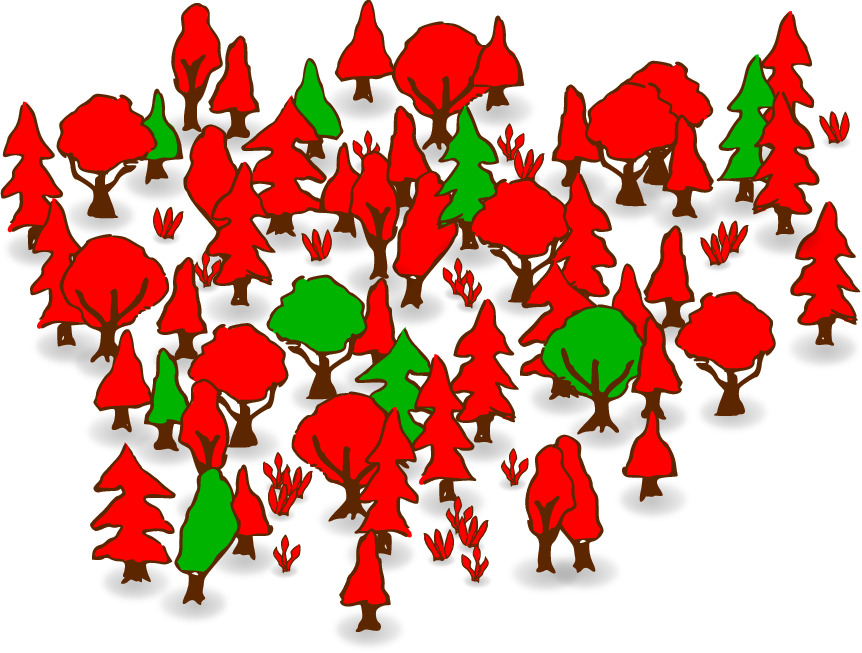



Príklad začneme načítaním dátovej množiny [Titanic](https://www.kaggle.com/c/titanic). Keďže sme s touto dátovou množinou už pracovali a vieme ako ju predspracovať, nebudeme to isté cvičenie opakovať znovu. Kód potrebný na načítanie a predspracovanie dát je v nasledujúcej bunke a kvôli stručnosti je skrytý.



In [ ]:
#@title -- Loading and Preprocessing the Data -- { display-mode: "form" }
df = pd.read_csv("data/titanic/train.csv")
df_train, df_test = train_test_split(df, test_size=0.25,
                     stratify=df["Survived"], random_state=4)

categorical_inputs = ["Pclass", "Sex", "Embarked"]
numeric_inputs = ["Age", "SibSp", 'Parch', 'Fare']

output = "Survived"

input_preproc = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder()),
     categorical_inputs),
    
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()),
     numeric_inputs)
)

X_train = input_preproc.fit_transform(df_train[categorical_inputs+numeric_inputs])
Y_train = df_train[output].values.reshape(-1)

X_test = input_preproc.transform(df_test[categorical_inputs+numeric_inputs])
Y_test = df_test[output].values.reshape(-1)

### Rozhodovací strom

Na začiatok si natrénujeme rozhodovací strom, ktorý nám poslúži ako základný model, s ktorým budeme provnávať komisie. Na testovanie modelov budeme znovu používať **krížovú validáciu**  a testovaciu množinu si odložíme až na testovanie finálneho modelu.



In [ ]:
model = DecisionTreeClassifier(
    min_samples_leaf=35
)

cross_validate(model, X_train, Y_train, cv=10)['test_score'].mean()

### XGBoost

Ako prvú komisnú metódu si vyskúšame metódu XGBoost: extrémny gradientný boosting. Gradientný boosting využíva metódu klesajúceho gradientu, avšak namiesto toho, aby sa pridávali inkrementy ku parametrom modelu, pridávajú sa celé nové modely do komisie. Každý nový model sa pritom nesnaží nezávisle riešiť celú úlohu, ale sa len snaží korigovať chyby tých predchádzajúcich.

Výsledky sa môžu líšiť podľa počtu estimátorov, ktorý použijeme: ak ich bude primálo, komisia nebude omnoho expresívnejšia než jeden strom, ale ak ich použijeme priveľa, komisia môže zase mať tendenciu preučiť sa. Môžeme teda vyskúšať viacero rôznych nastavení pre `n_estimators` a pomocou krížovej validácie identifikovať hodnotu pri ktorej sa zdá, že na našich dátach funguje najlepšie (všimnite si, že na porovnávanie výsledkov používame znovu krížovú validáciu a nie testovaciu množinu).



In [ ]:
model = XGBClassifier(n_estimators=10)
cross_validate(model, X_train, Y_train, cv=10)['test_score'].mean()

Výsledky by mali byť o niečo lepšie než v prípade rozhodovacieho stromu.

### LightGBM

LightGBM je prístup ku tréningu gradientnému boosting-u s rozhodovacími stromami, ale s niekoľkými vylepšeniami, vďaka ktorým je učenie omnoho rýchlejšie, väčšinou pri dosiahnutí porovnateľnej úspešnosti. Parameter `n_estimators` môžeme znovu ručne ladiť pomocou krížovej validácie.



In [ ]:
model = LGBMClassifier(n_estimators=30)
cross_validate(model, X_train, Y_train, cv=10)['test_score'].mean()

### Testovanie finálneho modelu

Pri písaní notebooku sme prišli na to, že LightGBM dosahuje v krížovej validácii o niečo lepšie skóre než XGBoost (aspoň pri hyperparametroch, ktoré sme vyskúšali) a preto sme sa ho rozhodli použiť ako náš finálny model, ktorý aplikujeme na testovaciu množinu.



In [ ]:
model = LGBMClassifier(n_estimators=30)
model.fit(X_train, Y_train)

In [ ]:
y_test = model.predict(X_test)
accuracy_score(Y_test, y_test)